# Pokemon Singles Battle Predictor

## 1. Introduction
This notebook explores Pokemon from Gen I to Gen VII, the generations I grew up with, and predicts the winner of a singles (1v1) battle. 
<br> <br>
The notebook uses data from Weedle's dojo which has Pokemon base stats from Gen I to Gen VI. I scrapped and added the Gen VII pokemon stats. This information was taken from Bulbapedia. The format of Gen VIII, the most recent generation, removes mega evolutions and essentially sets itself apart from the other generations so I decided to exclude it. Gen VII does not introduce mega evolutions of Pokemon whose base form first appeared in Gen VII.
<br> <br>
The purpose of this model and notebook is not to make Pokemon Showdown matches trivial given the accuracy of the model but instead, introduce players to the intuitive process behind competitve play. Similarly, the model is not as robust as one may dream for since if it were perfect, it would be cheating. Likewise, singles is not a popular format as Pokemon team combinations make every game unique and often more enjoyable. However, the flagship series games focus primarily on the singles battle format which means that this notebook lends to the transition from singles to the metagame. Ultimately, the model serves as a way to start team building which in my experience is the barrier of entry into this scene.

## 2. Data

### 2.1 Pokemon
Some Pokemon have alternate forms that are not considered evolutions. I have added those manually if they were missing.

In [1]:
import pandas as pd
df_pokemon = pd.read_csv("pokemon.csv")
df_pokemon.shape

(901, 12)

900 Pokemon, let's meet them...

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://theawesomer.com/photos/2018/01/pokemon_draw_em_all_poster_1.jpg", unconfined=True)

# Uncomment the remaining lines of code for a smaller image
#html1 = '<img src="https://theawesomer.com/photos/2018/01/pokemon_draw_em_all_poster_1.jpg" width="360" height="360" align="center"/>'
#HTML(html1)

As you can already tell, there are a lot of wonderful Pokemon to work with. 
* In fact, there are many Pokemon in the image that not in the dataframe. These are exlcusive Pokemon that appear in movies, mangas and other spinoff games. Can you identify them?

Anyways, I will not anlyze these Pokemon since they cannot be objectively compared. Let's learn more about the Pokemon from the dataframe through their base stats. 

In [3]:
df_pokemon.columns

Index(['#', 'Name', 'Type 1', 'Type 2', 'HP', 'Attack', 'Defense', 'Sp. Atk',
       'Sp. Def', 'Speed', 'Generation', 'Legendary'],
      dtype='object')

These stats are unqiue to each Pokemon species. Typically, Pokemon are trained from level 1 to level 100. As a Pokemon levels up, their stats, the numerical features in the dataframe above, increase. The exact change for each level is determined by several factors including: effort values (EV), individual values (IV), and base stats. 
* Effort values are essentially points in a that can be distributed to certain stats. The maximum amount of points available is the same across all Pokemon. 
* Individual values are points on a scale from 0 to 31 for each numerical feature in the dataframe above that serve as natural limits on a Pokemon. This means that Pokemon of the same species are not all inherently equal statwise. 
* Base stats are the values used in damage calculation and are scaled by level, EV and IV.

### Features

* "#" - Originally the Pokedex number of a Pokemon but with the introduction of alternate forms and Mega Evolutions, this feature is simply a unique identifier apart from the species name
* Name - Pokemon species name
* Type 1 - Pokemon type, every Pokemon has at least 1 type under normal circumstances
> Pokemon types are elements that provide defensive and offensive attributes in battles
* Type 2 - Some Pokemon have a another type
* Generation - Orginal generation the Pokemon was introduced in, 1-7. 
* Legendary - True if the Pokemon is considered a legendary pokemon (for simplicity, mythical pokemon are classified as legnedary too), False otherwise


Base Stats:
* HP - Hit points base stat.
* Attack - Physical attack base stat. Contact or phyiscal moves depend on this stat.
* Defense - Physical defense base stat. Typically used to determine the hit points lost from a contact or physical move
* Sp. Atk - Special attack base stat. Contactless or special moves depend on this stat.
* Sp. Def - Special defense base stat. Typically used to determine the hit points lost from a contactless or special move
* Speed - Speed base stat. Determines order of attacking in a turn. Under normal cirucmstances, a higher speed moves first.

In [4]:
df_pokemon.tail(901-802)

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
802,803,Rowlet,Grass,Flying,68,55,55,50,50,42,7,False
803,804,Dartrix,Grass,Flying,78,75,75,70,70,52,7,False
804,805,Decidueye,Grass,Ghost,78,107,75,100,100,70,7,False
805,806,Litten,Fire,NaN,45,65,40,60,40,70,7,False
806,807,Torracat,Fire,NaN,65,85,50,80,50,90,7,False
...,...,...,...,...,...,...,...,...,...,...,...,...
896,897,Stakataka,Rock,Steel,61,131,211,53,101,13,7,True
897,898,Blacephalon,Fire,Ghost,53,127,53,151,79,107,7,True
898,899,Zeraora,Electric,NaN,88,112,75,102,80,143,7,True
899,900,Meltan,Steel,NaN,46,65,65,55,35,34,7,True


I have already manually added Generation VII Pokemon but as always, we need to check for completeness.

In [5]:
df_pokemon.isnull().sum()

#               0
Name            0
Type 1          0
Type 2        423
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

There was a pokemon missing in this dataset of Gen I to Gen VI. I can easily tell that this is Primeape since it is the evolved form of the pokemon in the row above, Mankey. The output above shows zero for several features rather than one since I already added Primeape with stats. 

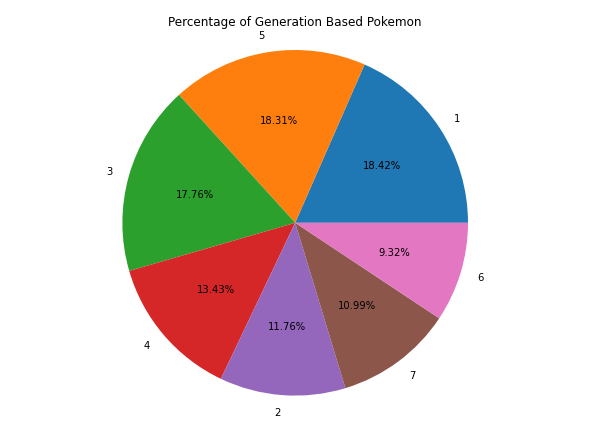

In [6]:
# Let's see how many Pokemon are in each generation

import matplotlib.pyplot as plt

generation = dict(df_pokemon.Generation.value_counts())
generationCount = generation.values()
generationNumber = generation.keys()

fig = plt.figure(figsize = (8,6))
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')

fig.suptitle("Percentage of Generation Based Pokemon")

plt.pie(generationCount, labels = generationNumber, autopct = '%1.2f%%')
plt.show()

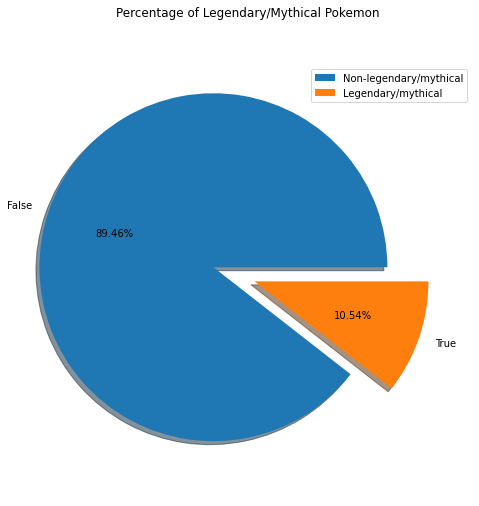

In [7]:
# How many Pokemon are legendary or Mythical?

legendaries =  dict(df_pokemon['Legendary'].value_counts())
legendaryCount = legendaries.values() 
legendariesLabel = legendaries.keys()

fig = plt.figure(figsize=(8, 8))
# Reuse same axis as before. When the feature is deprecated, reinstantiate the ax variable
plt.suptitle("Percentage of Legendary/Mythical Pokemon")

plt.pie(legendaryCount, labels = legendariesLabel, autopct = '%1.2f%%', shadow = True, explode = (0.25,0))
plt.legend(['Non-legendary/mythical', 'Legendary/mythical'], loc = 'upper right')
plt.show()

Roughly 10% of Pokemon are Legendary or Mythical, which is great. If there were fewer generations, this percentage would be lower. With regards to base stats, legendary and mythical Pokemon are usually outliers.

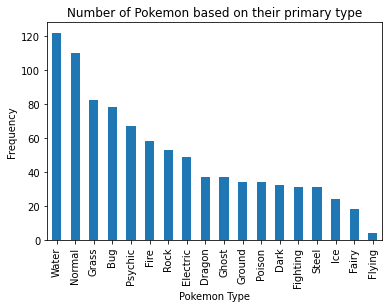

In [8]:
# Number of Pokemon of each type (18 total)

ax = df_pokemon["Type 1"].value_counts().plot(kind = 'bar', title = "Number of Pokemon based on their primary type")
ax.set_xlabel("Pokemon Type")
ax.set_ylabel("Frequency")

plt.show()

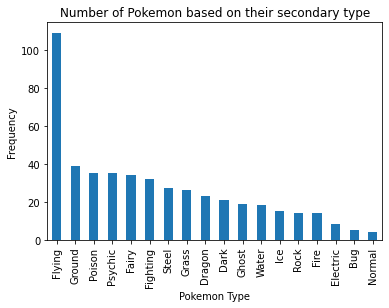

In [9]:
ax = df_pokemon["Type 2"].value_counts().plot(kind = 'bar', title = "Number of Pokemon based on their secondary type")
ax.set_xlabel("Pokemon Type")
ax.set_ylabel("Frequency")

plt.show()

Flying type is one of the most common secondary types. In the primary type plot above, the flying type Pokemon do not have a secondary type. Traditionally, when viewing Pokemon in battle or in the Pokedex, 'type 1' appears before 'type 2'. One type does not overwhelm the other, it is simply the order that they appear.

In my analysis and model, I will not remove the secondary type feature since that defeats the purpose of effective battling. Instead, I will fill the missing values with 'Not Applicable' or 'NA'.

In [10]:
df_pokemon["Type 2"] = df_pokemon["Type 2"].fillna("NA")

In [11]:
df_pokemon.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NA,39,52,43,60,50,65,1,False


Type 1 and Type 2 features are categorical which we can interpret but models work on numbers so we need to convert. A common technique would be one hot encoding but that would at a lot more columns than desired. There are 18 different types and they define two features so that would be inefficient. Instead, a FeatureHasher would be better here.

In [12]:
# Different types of features = 18
# 2^5 = 32 is larger than 18 but greater than 2^4 = 16
# Although this is small, best practice is to make this value high to avoid hashing collision

from sklearn.feature_extraction import FeatureHasher

primaryType = FeatureHasher(n_features = 5, input_type = 'string')
stringPrimary = primaryType.fit_transform(df_pokemon["Type 1"])
stringPrimary = pd.DataFrame(data = stringPrimary.toarray())

secondaryType = FeatureHasher(n_features = 5, input_type = 'string')
stringSecondary = secondaryType.fit_transform(df_pokemon["Type 2"])
stringSecondary = pd.DataFrame(data = stringSecondary.toarray())

df_pokemon = df_pokemon.drop(columns = ["Type 1", "Type 2"])
df_pokemon = pd.concat([df_pokemon, stringPrimary, stringSecondary], axis = 1)

In [13]:
df_pokemon.head()

,#,Name,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,0,1,2,3,4,0,1,2,3,4
0,1,Bulbasaur,45,49,49,65,65,45,1,False,2.0,0.0,0.0,0.0,-1.0,0.0,-2.0,0.0,2.0,-2.0
1,2,Ivysaur,60,62,63,80,80,60,1,False,2.0,0.0,0.0,0.0,-1.0,0.0,-2.0,0.0,2.0,-2.0
2,3,Venusaur,80,82,83,100,100,80,1,False,2.0,0.0,0.0,0.0,-1.0,0.0,-2.0,0.0,2.0,-2.0
3,4,Mega Venusaur,80,100,123,122,120,80,1,False,2.0,0.0,0.0,0.0,-1.0,0.0,-2.0,0.0,2.0,-2.0
4,5,Charmander,39,52,43,60,50,65,1,False,1.0,-1.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Finally, I chose to combine the Legendary/Mythical Pokemon label into one feature to make the result binary
# True = 1
# False = 0

df_pokemon.Legendary = df_pokemon.Legendary.astype(int)

In [15]:
df_pokemon.head()

,#,Name,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,0,1,2,3,4,0,1,2,3,4
0,1,Bulbasaur,45,49,49,65,65,45,1,0,2.0,0.0,0.0,0.0,-1.0,0.0,-2.0,0.0,2.0,-2.0
1,2,Ivysaur,60,62,63,80,80,60,1,0,2.0,0.0,0.0,0.0,-1.0,0.0,-2.0,0.0,2.0,-2.0
2,3,Venusaur,80,82,83,100,100,80,1,0,2.0,0.0,0.0,0.0,-1.0,0.0,-2.0,0.0,2.0,-2.0
3,4,Mega Venusaur,80,100,123,122,120,80,1,0,2.0,0.0,0.0,0.0,-1.0,0.0,-2.0,0.0,2.0,-2.0
4,5,Charmander,39,52,43,60,50,65,1,0,1.0,-1.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0


I am not dropping the Name column since it is still useful for mapping what Pokemon wins the battle.

### 2.2 Battles

I used the "combat.csv" data from Kaggle which I like since the first pokemon win count to second pokemon win count ratio is about 1. I could not find combat data on Generation VII. However, whenever a new generation is introduced, stats are rebalanced where necessary so testing battles with Generation VII is great since it is fresh. I will verify manually if the predictions are correct if the battles involve at least one Pokemon with a '#' feature greater than or equal to 803. 

In [16]:
df_combat = pd.read_csv("combats.csv")

In [17]:
df_combat.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


In [18]:
import numpy as np

# For each row, concatenate the data

buffer = []
for i in df_combat.itertuples():
    firstPokemon = i[1]
    secondPokemon = i[2]
    winner = i[3]
    
    first = df_pokemon.loc[df_pokemon["#"] == firstPokemon].values[:, 2:][0]
    second = df_pokemon.loc[df_pokemon["#"] == secondPokemon].values[:, 2:][0]
    difference = (first - second)[:6]
    data = np.concatenate((first, second))
    
    if winner == firstPokemon:
        data = np.append(data, [0])
    else:
        data = np.append(data, [1])
    buffer.append(data)

# List to numpy array
data = np.asarray(buffer)

## 3. Model

In [19]:
# Split data into training and testing

from sklearn.model_selection import train_test_split

X = data[:, :-1].astype(int)
y = data[:, -1].astype(int) # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 69)

In [21]:
# Instantiate and fit model

from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators = 101)
model = classifier.fit(X_train, y_train)

In [22]:
# Evaluate
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Accuracy
pred = model.predict(X_test)
print('Accuracy: {}'.format(accuracy_score(pred, y_test)))
# Classification report
print(classification_report(y_test, pred))

Accuracy: 0.944
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4784
           1       0.95      0.95      0.95      5216

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



Over 90%, great. Let's predict... 

Bulbasaur, I choose you!

In [23]:
# Bulbasaur, I also choose you!
model.predict([[45,49,49,65,65,45,1,0,2.0,0.0,0.0,0.0,-1.0,0.0,-2.0,0.0,2.0,-2.0, 45,49,49,65,65,45,1,0,2.0,0.0,0.0,0.0,-1.0,0.0,-2.0,0.0,2.0,-2.0]])

array([1])

Ok, so that was a Bulbasaur vs another Bulbasaur. Of course, Bulbasaur won. Based on python arrray indexing, the second bulbasaur won. What if we swap out the first Bulbasaur with Volcanion, a Pokemon that I am confident will win.

In [24]:
# You got this Volcanion!
model.predict([[80,110,120,130,90,70,6,1,1.0,-1.0,0.0,-1.0,1.0,2.0,0.0,0.0,0.0,-1.0, 45,49,49,65,65,45,1,0,2.0,0.0,0.0,0.0,-1.0,0.0,-2.0,0.0,2.0,-2.0]])

array([0])

Volcanion won! 

Before I had mentioned that I manually added Gen VII Pokemon, let's see if this model will hold.

In [25]:
model.predict([[45,49,49,65,65,45,1,0,2.0,0.0,0.0,0.0,-1.0,0.0,-2.0,0.0,2.0,-2.0,97,157,127,113,109,77,7,1,-1.0,-2.0,-2.0,0.0,0.0,0.0,0.0,1.0,-1.0,1.0]])

array([1])

Here, I matched up Bulbasaur against Dusk Mane Necrozma. Of course, Necrozma won. This model holds for this generation as well which is great since it is more useful with better data.

However, you may be a bit confused on the input to the predict method.

The three code cells above currently represent the formatting of the input. Notice the 2D array input with 36 values. This 36 is split into two Pokemon, each with 18 features. Essentially, the features include everything to the right of the 'Name' feature in the dataframe. To confirm this logic, let's look at the X_test matrix and the df_combat dataframe.

In [26]:
print(X_test.shape)
print(df_combat.shape)
X_test

(10000, 36)
(50000, 3)


array([[ 55,  20,  35, ...,  -1,   0,   2],
       [ 59,  74,  50, ...,   0,   0,   0],
       [216, 100, 121, ...,   0,  -1,   1],
       ...,
       [ 55,  55,  50, ...,  -1,   1,   1],
       [250,   5,   5, ...,   0,  -1,   0],
       [108, 170, 115, ...,   0,   0,  -1]])

X_test is a 2D matrix with the 36 features or columns. For each row or Pokemon battle, there are 18 features as expected since we are comparing two Pokemon. Remember, the target or which Pokemon won is not on here. To account for the number of rows or battles, we can see that the combat.csv has 50000 battle results and from the train_test_split we take 20% of all the data for testing. 

Now, everyone can use this model to play out some battles.

### Future work



* Simplify the inputs to the predict method for users (Pipeline this) <br> <br>
Method: <br> 
> User inputs a string when prompted for first Pokemon and another for second Pokemon <br> Store as two string variables, which on the modified df_pokemon dataframe map to two rows of features (cannot be the same) <br> Check for valid user input <br> Also make a list of the two strings to return the winner when determined <br> Extract the features to the right of 'name' to store as a list for each Pokemon <br> Concatenate the two lists in order <br> Feed concatenated list into predict. The output, either an array with 0 or 1 will be used as the index to the array of two strings. Return the corresponding string as the winner.
* Deploy as an application which makes the experience visually appealing